In [1]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F
from torch import nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
train = pd.read_csv("../train_dataset.csv", header=None)

In [3]:
train.columns = ["wt", "mut", "score", "pos"]

In [4]:
# !pip install fair-esm

In [5]:
import esm

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
SEED = 42
TRAIN_SIZE = 7000

In [8]:
data = train.sample(frac=1.0, random_state=SEED)

In [9]:
train_df = data.iloc[:TRAIN_SIZE, :]
valid_df = data.iloc[TRAIN_SIZE:, :]

In [10]:
train_df.index = np.arange(0, len(train_df))
valid_df.index = np.arange(0, len(valid_df))

In [11]:
class Protseq(Dataset):
    def __init__(self, df):
        self.df = df
        _, esm1v_alphabet = esm.pretrained.esm2_t33_650M_UR50D()
        self.esm1v_batch_converter = esm1v_alphabet.get_batch_converter()

        
    def __getitem__(self, idx):
        _, _, wt = self.esm1v_batch_converter([('' , ''.join(self.df.loc[idx, "wt"]))])
        _, _, mut = self.esm1v_batch_converter([('' , ''.join(self.df.loc[idx, "mut"]))])
        pos = self.df.loc[idx, "pos"]
        target = torch.FloatTensor([self.df.loc[idx, "score"]])
        return wt, mut, pos, target

    
    def __len__(self):
        return len(self.df)

In [12]:
BATCH_SIZE = 1

In [13]:
train_ds = Protseq(train_df)
valid_ds = Protseq(valid_df)

In [14]:
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)


In [15]:
HIDDEN_UNITS_POS_CONTACT = 5
class ESM_sum_sequence(nn.Module):
    def __init__(self):
        super().__init__()
        self.esm2, _ = esm.pretrained.esm2_t33_650M_UR50D()
        self.fc1 = nn.Linear(1280, HIDDEN_UNITS_POS_CONTACT)
        self.fc2 = nn.Linear(HIDDEN_UNITS_POS_CONTACT, 1)
    
    
    def _freeze_esm2_layers(self):
        total_blocks = 33
        initial_layers = 2
        layers_per_block = 16
        num_freeze_blocks = total_blocks - 3
        for _, param in list(self.esm2.named_parameters())[
            :initial_layers + layers_per_block * num_freeze_blocks]:
            param.requires_grad = False
            

    def forward(self, token_ids1, token_ids2):
        outputs1 = self.esm2.forward(token_ids1, repr_layers=[33])[
            'representations'][33]
        outputs2 = self.esm2.forward(token_ids2, repr_layers=[33])[
            'representations'][33]
        outputs1_mean = outputs1.mean(1)
        outputs2_mean = outputs2.mean(1)
        add = outputs1_mean + outputs2_mean
        fc1_outputs = F.relu(self.fc1(add))
        logits = self.fc2(fc1_outputs)
        return logits

In [16]:
HIDDEN_UNITS_POS_CONTACT = 5
class ESM_concat_mut(nn.Module):
    def __init__(self):
        super().__init__()
        self.esm2, _ = esm.pretrained.esm2_t33_650M_UR50D()
        self.fc1 = nn.Linear(1280*2, HIDDEN_UNITS_POS_CONTACT)
        self.fc2 = nn.Linear(HIDDEN_UNITS_POS_CONTACT, 1)
    
    
    def _freeze_esm2_layers(self):
        total_blocks = 33
        initial_layers = 2
        layers_per_block = 16
        num_freeze_blocks = total_blocks - 3
        for _, param in list(self.esm2.named_parameters())[
            :initial_layers + layers_per_block * num_freeze_blocks]:
            param.requires_grad = False
            

    def forward(self, wt_ids, mut_ids, pos):
        outputs1 = self.esm2.forward(wt_ids, repr_layers=[33])[
            'representations'][33]
        outputs2 = self.esm2.forward(mut_ids, repr_layers=[33])[
            'representations'][33]
        wt_pos = outputs1[:, pos, :].squeeze(1)
        mut_pos = outputs2[:, pos, :].squeeze(1)
        pos_concat = torch.cat((wt_pos, mut_pos), 1)
        fc1_outputs = F.relu(self.fc1(pos_concat))
        logits = self.fc2(fc1_outputs)
        return logits

In [17]:
from torchmetrics.regression import SpearmanCorrCoef

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def train(train_dataloader, model, epochs):
    model.train()
    
    # metric = SpearmanCorrCoef()
    # metric_values = []
    for _ in range(epochs):
        tr_loss = 0
        nb_tr_steps = 0
        
        
        for batch in tqdm(train_dataloader):
            wt_ids, mut_ids, pos, labels = batch
            wt_ids.squeeze_(1).to(device)
            mut_ids.squeeze_(1).to(device)
            labels = labels.to(device)
            logits = model(wt_ids, mut_ids, pos)
            loss = torch.nn.functional.mse_loss(logits, labels)
            tr_loss += loss.item()
            nb_tr_steps += 1
            
            torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=0.1
            )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = tr_loss / nb_tr_steps
        print(f"Training loss epoch: {epoch_loss}")
        # metrics
        # preds = 
        # target = valid_df.score
        # metric_values.append(metric(preds, target))
    
    # Plot metrics
    # fig, ax = metric.plot(values)

In [19]:
lr = 1e-5
EPOCHS = 3

In [68]:
model = ESM_concat_mut()
model= nn.DataParallel(model) # add to use all 
model.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

In [40]:
model

DataParallel(
  (module): ESM_concat_mut(
    (esm2): ESM2(
      (embed_tokens): Embedding(33, 1280, padding_idx=1)
      (layers): ModuleList(
        (0-32): 33 x TransformerLayer(
          (self_attn): MultiheadAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (rot_emb): RotaryEmbedding()
          )
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
          (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        )
      )
      (contact_head): ContactPredictionHead(
        (regression): Linear(

In [69]:
train(train_dataloader, model, EPOCHS)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 7000/7000 [34:07<00:00,  3.42it/s]


Training loss epoch: 0.0425466416905237


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 7000/7000 [34:07<00:00,  3.42it/s]


Training loss epoch: 0.025464285868838588


100%|█████████████████████████████████████████████████████████████████████████████████████| 7000/7000 [34:03<00:00,  3.43it/s]

Training loss epoch: 0.01931057652196221


In [23]:
def valid(model, valid_dataloader):
    model.eval()
    y_pred = []
    y_true = []
    for batch in tqdm(valid_dataloader):
        wt_ids, mut_ids, pos, labels = batch
        wt_ids = wt_ids.squeeze(1).to(device)
        mut_ids = mut_ids.squeeze(1).to(device)
        labels = labels.to(device)
        labels = labels.detach().cpu().numpy()
        logits = model(wt_ids, mut_ids, pos)
        logits = logits.detach().cpu().numpy()
        y_pred.append(logits)
        y_true.append(labels)
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    return y_pred, y_true

In [71]:
# torch.save(model, '../models/MutPos.pt')

In [20]:
model = torch.load('../models/MutPos.pt')
model.eval()

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


DataParallel(
  (module): ESM_concat_mut(
    (esm2): ESM2(
      (embed_tokens): Embedding(33, 1280, padding_idx=1)
      (layers): ModuleList(
        (0-32): 33 x TransformerLayer(
          (self_attn): MultiheadAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (rot_emb): RotaryEmbedding()
          )
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
          (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        )
      )
      (contact_head): ContactPredictionHead(
        (regression): Linear(

In [24]:
y_pred, y_true = valid(model, valid_dataloader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1539/1539 [02:12<00:00, 11.64it/s]


In [26]:
from scipy.stats import spearmanr
spearmanr(y_pred, y_true)

SignificanceResult(statistic=0.8036465597174891, pvalue=0.0)

In [28]:
test = pd.read_csv("./single_test.csv", header=None)
test.columns = ["wt", "mut", "score", "pos"]
test_ds = Protseq(test)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [29]:
y_pred, y_true = valid(model, test_dataloader)
spearmanr(y_pred, y_true)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 492/492 [00:41<00:00, 11.72it/s]


SignificanceResult(statistic=0.7779809603886108, pvalue=5.79191860531809e-101)

In [120]:
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
plt.xkcd()

df = pd.DataFrame([y_pred, y_true]).transpose()
df.columns = ['prediction', 'true']

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
f

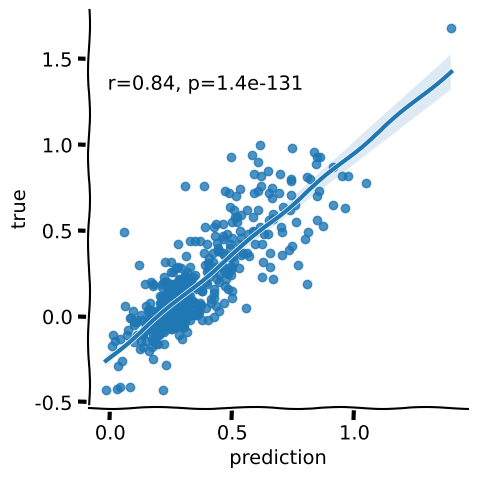

In [123]:
g = sns.lmplot(df, x = 'prediction', y = 'true')

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['prediction'], data['true'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

g.map_dataframe(annotate)

plt.savefig('SpearmanCorMutPosSingle.png')
plt.show()